## Yield Oracles:  Predicting Soybean Yields in Brazil Using Satellite and Weather Data

This code was written as part of a project to satisfy the [Capstone Course](https://datascience.berkeley.edu/academics/curriculum/synthetic-capstone-course/) requirement of the [UC Berkeley Master of Information and Data Science](https://datascience.berkeley.edu) program.  Our project was completed in April 2016.  For more details and to see our results, please visit our [website](http://amitavadas.github.io/capstone/index.html).  We look forward to your feedback!

For questions and comments about this code, please contact the author, Marguerite Oneto, by email at <marguerite.oneto@ischool.berkeley.edu>.

# Run A Gated Recurrent Units (GRU) Model Using Theano
This code is based on an excellent tutorial by Denny Britz giving an introduction to Gated Recurrent Units.  Please see the links below for more information.  
Reference:  http://www.wildml.com/2015/10/recurrent-neural-network-tutorial-part-4-implementing-a-grulstm-rnn-with-python-and-theano/   
Reference:  https://github.com/dennybritz/rnn-tutorial-gru-lstm/blob/master/gru_theano.py   
Data for Unit Test:  https://github.com/maoneto/W210/blob/master/Code/data/reddit-comments-2015-trunc.csv   
Data for Yield Prediction Test:  https://github.com/maoneto/W210/blob/master/Code/data/train_trajectories_11_images_max_mv_trunc10000.csv

## GRU Unit Test

### Define GRUTheano Class for Unit Test

In [1]:
%%writefile gru_theano_ut.py

import numpy as np
import theano as theano
import theano.tensor as T
from theano.gradient import grad_clip
import time
import operator

class GRUTheanoUT:
    
    def __init__(self, word_dim, hidden_dim=128, bptt_truncate=-1):
        # Assign instance variables
        self.word_dim = word_dim
        self.hidden_dim = hidden_dim
        self.bptt_truncate = bptt_truncate
        # Initialize the network parameters
        E = np.random.uniform(-np.sqrt(1./word_dim), np.sqrt(1./word_dim), (hidden_dim, word_dim))
        U = np.random.uniform(-np.sqrt(1./hidden_dim), np.sqrt(1./hidden_dim), (6, hidden_dim, hidden_dim))
        W = np.random.uniform(-np.sqrt(1./hidden_dim), np.sqrt(1./hidden_dim), (6, hidden_dim, hidden_dim))
        V = np.random.uniform(-np.sqrt(1./hidden_dim), np.sqrt(1./hidden_dim), (word_dim, hidden_dim))
        b = np.zeros((6, hidden_dim))
        c = np.zeros(word_dim)
        # Theano: Created shared variables
        self.E = theano.shared(name='E', value=E.astype(theano.config.floatX))
        self.U = theano.shared(name='U', value=U.astype(theano.config.floatX))
        self.W = theano.shared(name='W', value=W.astype(theano.config.floatX))
        self.V = theano.shared(name='V', value=V.astype(theano.config.floatX))
        self.b = theano.shared(name='b', value=b.astype(theano.config.floatX))
        self.c = theano.shared(name='c', value=c.astype(theano.config.floatX))
        # SGD / rmsprop: Initialize parameters
        self.mE = theano.shared(name='mE', value=np.zeros(E.shape).astype(theano.config.floatX))
        self.mU = theano.shared(name='mU', value=np.zeros(U.shape).astype(theano.config.floatX))
        self.mV = theano.shared(name='mV', value=np.zeros(V.shape).astype(theano.config.floatX))
        self.mW = theano.shared(name='mW', value=np.zeros(W.shape).astype(theano.config.floatX))
        self.mb = theano.shared(name='mb', value=np.zeros(b.shape).astype(theano.config.floatX))
        self.mc = theano.shared(name='mc', value=np.zeros(c.shape).astype(theano.config.floatX))
        # We store the Theano graph here
        self.theano = {}
        self.__theano_build__()
    
    def __theano_build__(self):
        E, V, U, W, b, c = self.E, self.V, self.U, self.W, self.b, self.c
        
        x = T.ivector('x')
        y = T.ivector('y')
        
        def forward_prop_step(x_t, s_t1_prev, s_t2_prev):
            # This is how we calculated the hidden state in a simple RNN. No longer!
            # s_t = T.tanh(U[:,x_t] + W.dot(s_t1_prev))
            
            # Word embedding layer
            x_e = E[:,x_t]
            
            # GRU Layer 1
            z_t1 = T.nnet.hard_sigmoid(U[0].dot(x_e) + W[0].dot(s_t1_prev) + b[0])
            r_t1 = T.nnet.hard_sigmoid(U[1].dot(x_e) + W[1].dot(s_t1_prev) + b[1])
            c_t1 = T.tanh(U[2].dot(x_e) + W[2].dot(s_t1_prev * r_t1) + b[2])
            s_t1 = (T.ones_like(z_t1) - z_t1) * c_t1 + z_t1 * s_t1_prev
            
            # GRU Layer 2
            z_t2 = T.nnet.hard_sigmoid(U[3].dot(s_t1) + W[3].dot(s_t2_prev) + b[3])
            r_t2 = T.nnet.hard_sigmoid(U[4].dot(s_t1) + W[4].dot(s_t2_prev) + b[4])
            c_t2 = T.tanh(U[5].dot(s_t1) + W[5].dot(s_t2_prev * r_t2) + b[5])
            s_t2 = (T.ones_like(z_t2) - z_t2) * c_t2 + z_t2 * s_t2_prev
            
            # Final output calculation
            # Theano's softmax returns a matrix with one row, we only need the row
            o_t = T.nnet.softmax(V.dot(s_t2) + c)[0]

            return [o_t, s_t1, s_t2]
        
        [o, s, s2], updates = theano.scan(
            forward_prop_step,
            sequences=x,
            truncate_gradient=self.bptt_truncate,
            outputs_info=[None, 
                          dict(initial=T.zeros(self.hidden_dim)),
                          dict(initial=T.zeros(self.hidden_dim))])
        
        prediction = T.argmax(o, axis=1)
        o_error = T.sum(T.nnet.categorical_crossentropy(o, y))
        
        # Total cost (could add regularization here)
        cost = o_error
        
        # Gradients
        dE = T.grad(cost, E)
        dU = T.grad(cost, U)
        dW = T.grad(cost, W)
        db = T.grad(cost, b)
        dV = T.grad(cost, V)
        dc = T.grad(cost, c)
        
        # Assign functions
        self.predict = theano.function([x], o)
        self.predict_class = theano.function([x], prediction)
        self.ce_error = theano.function([x, y], cost)
        self.bptt = theano.function([x, y], [dE, dU, dW, db, dV, dc])
        
        # SGD parameters
        learning_rate = T.scalar('learning_rate')
        decay = T.scalar('decay')
        
        # rmsprop cache updates
        mE = decay * self.mE + (1 - decay) * dE ** 2
        mU = decay * self.mU + (1 - decay) * dU ** 2
        mW = decay * self.mW + (1 - decay) * dW ** 2
        mV = decay * self.mV + (1 - decay) * dV ** 2
        mb = decay * self.mb + (1 - decay) * db ** 2
        mc = decay * self.mc + (1 - decay) * dc ** 2
        
        self.sgd_step = theano.function(
            [x, y, learning_rate, theano.Param(decay, default=0.9)],
            [], 
            updates=[(E, E - learning_rate * dE / T.sqrt(mE + 1e-6)),
                     (U, U - learning_rate * dU / T.sqrt(mU + 1e-6)),
                     (W, W - learning_rate * dW / T.sqrt(mW + 1e-6)),
                     (V, V - learning_rate * dV / T.sqrt(mV + 1e-6)),
                     (b, b - learning_rate * db / T.sqrt(mb + 1e-6)),
                     (c, c - learning_rate * dc / T.sqrt(mc + 1e-6)),
                     (self.mE, mE),
                     (self.mU, mU),
                     (self.mW, mW),
                     (self.mV, mV),
                     (self.mb, mb),
                     (self.mc, mc)
                    ])
        
        
    def calculate_total_loss(self, X, Y):
        return np.sum([self.ce_error(x,y) for x,y in zip(X,Y)])
    
    def calculate_loss(self, X, Y):
        # Divide calculate_loss by the number of words
        num_words = np.sum([len(y) for y in Y])
        return self.calculate_total_loss(X,Y)/float(num_words)  



Overwriting gru_theano_ut.py


### Define Theano Utility Functions from utils.py for Unit Test

In [2]:
%%writefile utils_ut.py

import csv
import itertools
import numpy as np
import nltk
import time
import sys
import operator
import io
import array
from datetime import datetime
from gru_theano_ut import GRUTheanoUT

SENTENCE_START_TOKEN = "SENTENCE_START"
SENTENCE_END_TOKEN = "SENTENCE_END"
UNKNOWN_TOKEN = "UNKNOWN_TOKEN"

def load_data(filename, vocabulary_size=2000, min_sent_characters=0):

    word_to_index = []
    index_to_word = []

    # Read the data and append SENTENCE_START and SENTENCE_END tokens
    print("Reading CSV file...")
    with open(filename, 'rt') as f:
        reader = csv.reader(f, skipinitialspace=True)
        reader.next()
        # Split full comments into sentences
        sentences = itertools.chain(*[nltk.sent_tokenize(x[0].decode("utf-8").lower()) for x in reader])
        # Filter sentences
        sentences = [s for s in sentences if len(s) >= min_sent_characters]
        sentences = [s for s in sentences if "http" not in s]
        # Append SENTENCE_START and SENTENCE_END
        sentences = ["%s %s %s" % (SENTENCE_START_TOKEN, x, SENTENCE_END_TOKEN) for x in sentences]
    print("Parsed %d sentences." % (len(sentences)))

    # Tokenize the sentences into words
    tokenized_sentences = [nltk.word_tokenize(sent) for sent in sentences]

    # Count the word frequencies
    word_freq = nltk.FreqDist(itertools.chain(*tokenized_sentences))
    print("Found %d unique words tokens." % len(word_freq.items()))

    # Get the most common words and build index_to_word and word_to_index vectors
    vocab = sorted(word_freq.items(), key=lambda x: (x[1], x[0]), reverse=True)[:vocabulary_size-2]
    print("Using vocabulary size %d." % vocabulary_size)
    print("The least frequent word in our vocabulary is '%s' and appeared %d times." % (vocab[-1][0], vocab[-1][1]))

    sorted_vocab = sorted(vocab, key=operator.itemgetter(1))
    index_to_word = ["<MASK/>", UNKNOWN_TOKEN] + [x[0] for x in sorted_vocab]
    word_to_index = dict([(w, i) for i, w in enumerate(index_to_word)])

    # Replace all words not in our vocabulary with the unknown token
    for i, sent in enumerate(tokenized_sentences):
        tokenized_sentences[i] = [w if w in word_to_index else UNKNOWN_TOKEN for w in sent]

    # Create the training data
    X_train = np.asarray([[word_to_index[w] for w in sent[:-1]] for sent in tokenized_sentences])
    y_train = np.asarray([[word_to_index[w] for w in sent[1:]] for sent in tokenized_sentences])

    return X_train, y_train, word_to_index, index_to_word


def train_with_sgd(model, X_train, y_train, learning_rate=0.001, nepoch=20, decay=0.9,
    callback_every=10000, callback=None):
    num_examples_seen = 0
    for epoch in range(nepoch):
        # For each training example...
        for i in np.random.permutation(len(y_train)):
            # One SGD step
            model.sgd_step(X_train[i], y_train[i], learning_rate, decay)
            num_examples_seen += 1
            # Optionally do callback
            if (callback and callback_every and num_examples_seen % callback_every == 0):
                callback(model, num_examples_seen)            
    return model

def save_model_parameters_theano(model, outfile):
    np.savez(outfile,
        E=model.E.get_value(),
        U=model.U.get_value(),
        W=model.W.get_value(),
        V=model.V.get_value(),
        b=model.b.get_value(),
        c=model.c.get_value())
    print "Saved model parameters to %s." % outfile

def load_model_parameters_theano(path, modelClass=GRUTheanoUT):
    npzfile = np.load(path)
    E, U, W, V, b, c = npzfile["E"], npzfile["U"], npzfile["W"], npzfile["V"], npzfile["b"], npzfile["c"]
    hidden_dim, word_dim = E.shape[0], E.shape[1]
    print "Building model model from %s with hidden_dim=%d word_dim=%d" % (path, hidden_dim, word_dim)
    sys.stdout.flush()
    model = modelClass(word_dim, hidden_dim=hidden_dim)
    model.E.set_value(E)
    model.U.set_value(U)
    model.W.set_value(W)
    model.V.set_value(V)
    model.b.set_value(b)
    model.c.set_value(c)
    return model 

def gradient_check_theano(model, x, y, h=0.001, error_threshold=0.01):
    # Overwrite the bptt attribute. We need to backpropagate all the way to get the correct gradient
    model.bptt_truncate = 1000
    # Calculate the gradients using backprop
    bptt_gradients = model.bptt(x, y)
    # List of all parameters we want to chec.
    model_parameters = ['E', 'U', 'W', 'b', 'V', 'c']
    # Gradient check for each parameter
    for pidx, pname in enumerate(model_parameters):
        # Get the actual parameter value from the mode, e.g. model.W
        parameter_T = operator.attrgetter(pname)(model)
        parameter = parameter_T.get_value()
        print "Performing gradient check for parameter %s with size %d." % (pname, np.prod(parameter.shape))
        # Iterate over each element of the parameter matrix, e.g. (0,0), (0,1), ...
        it = np.nditer(parameter, flags=['multi_index'], op_flags=['readwrite'])
        while not it.finished:
            ix = it.multi_index
            # Save the original value so we can reset it later
            original_value = parameter[ix]
            # Estimate the gradient using (f(x+h) - f(x-h))/(2*h)
            parameter[ix] = original_value + h
            parameter_T.set_value(parameter)
            gradplus = model.calculate_total_loss([x],[y])
            parameter[ix] = original_value - h
            parameter_T.set_value(parameter)
            gradminus = model.calculate_total_loss([x],[y])
            estimated_gradient = (gradplus - gradminus)/(2*h)
            parameter[ix] = original_value
            parameter_T.set_value(parameter)
            # The gradient for this parameter calculated using backpropagation
            backprop_gradient = bptt_gradients[pidx][ix]
            # calculate The relative error: (|x - y|/(|x| + |y|))
            relative_error = np.abs(backprop_gradient - estimated_gradient)/(np.abs(backprop_gradient) + np.abs(estimated_gradient))
            # If the error is to large fail the gradient check
            if relative_error > error_threshold:
                print "Gradient Check ERROR: parameter=%s ix=%s" % (pname, ix)
                print "+h Loss: %f" % gradplus
                print "-h Loss: %f" % gradminus
                print "Estimated_gradient: %f" % estimated_gradient
                print "Backpropagation gradient: %f" % backprop_gradient
                print "Relative Error: %f" % relative_error
                return 
            it.iternext()
        print "Gradient check for parameter %s passed." % (pname)


def print_sentence(s, index_to_word):
    sentence_str = [index_to_word[x] for x in s[1:-1]]
    print(" ".join(sentence_str))
    sys.stdout.flush()

def generate_sentence(model, index_to_word, word_to_index, min_length=5):
    # We start the sentence with the start token
    new_sentence = [word_to_index[SENTENCE_START_TOKEN]]
    # Repeat until we get an end token
    while not new_sentence[-1] == word_to_index[SENTENCE_END_TOKEN]:
        next_word_probs = model.predict(new_sentence)[-1]
        samples = np.random.multinomial(1, next_word_probs)
        sampled_word = np.argmax(samples)
        new_sentence.append(sampled_word)
        # Seomtimes we get stuck if the sentence becomes too long, e.g. "........" :(
        # And: We don't want sentences with UNKNOWN_TOKEN's
        if len(new_sentence) > 100 or sampled_word == word_to_index[UNKNOWN_TOKEN]:
            return None
    if len(new_sentence) < min_length:
        return None
    return new_sentence

def generate_sentences(model, n, index_to_word, word_to_index):
    for i in range(n):
        sent = None
        while not sent:
            sent = generate_sentence(model, index_to_word, word_to_index)
        print_sentence(sent, index_to_word)

Overwriting utils_ut.py


### Train GRU for Unit Test

In [3]:
#! /usr/bin/env python

import sys
import os
import time
import numpy as np
from utils_ut import *
from datetime import datetime
from gru_theano_ut import GRUTheanoUT

LEARNING_RATE = float(os.environ.get("LEARNING_RATE", "0.001"))
VOCABULARY_SIZE = int(os.environ.get("VOCABULARY_SIZE", "200"))
EMBEDDING_DIM = int(os.environ.get("EMBEDDING_DIM", "48"))
HIDDEN_DIM = int(os.environ.get("HIDDEN_DIM", "128"))
NEPOCH = int(os.environ.get("NEPOCH", "1"))
MODEL_OUTPUT_FILE = os.environ.get("MODEL_OUTPUT_FILE")
INPUT_DATA_FILE = os.environ.get("INPUT_DATA_FILE", "./data/reddit-comments-2015-trunc.csv")
PRINT_EVERY = int(os.environ.get("PRINT_EVERY", "25"))

if not MODEL_OUTPUT_FILE:
  ts = datetime.now().strftime("%Y-%m-%d-%H-%M")
  MODEL_OUTPUT_FILE = "GRU-%s-%s-%s-%s.dat" % (ts, VOCABULARY_SIZE, EMBEDDING_DIM, HIDDEN_DIM)

# Load data
x_train, y_train, word_to_index, index_to_word = load_data(INPUT_DATA_FILE, VOCABULARY_SIZE)

# Build model
model = GRUTheanoUT(VOCABULARY_SIZE, hidden_dim=HIDDEN_DIM, bptt_truncate=-1)

# Print SGD step time
t1 = time.time()
model.sgd_step(x_train[10], y_train[10], LEARNING_RATE)
t2 = time.time()
print "SGD Step time: %f milliseconds" % ((t2 - t1) * 1000.)
sys.stdout.flush()

# We do this every few examples to understand what's going on
def sgd_callback(model, num_examples_seen):
  dt = datetime.now().isoformat()
  loss = model.calculate_loss(x_train[:10000], y_train[:10000])
  print("\n%s (%d)" % (dt, num_examples_seen))
  print("--------------------------------------------------")
  print("Loss: %f" % loss)
  generate_sentences(model, 10, index_to_word, word_to_index)
  save_model_parameters_theano(model, MODEL_OUTPUT_FILE)
  print("\n")
  sys.stdout.flush()

for epoch in range(NEPOCH):
  train_with_sgd(model, x_train, y_train, learning_rate=LEARNING_RATE, nepoch=1, decay=0.9, 
    callback_every=PRINT_EVERY, callback=sgd_callback)

Reading CSV file...
Parsed 94 sentences.
Found 632 unique words tokens.
Using vocabulary size 200.
The least frequent word in our vocabulary is 'we' and appeared 1 times.
SGD Step time: 58.140039 milliseconds

2016-04-25T18:34:47.266062 (25)
--------------------------------------------------
Loss: 4.135619
myself SENTENCE_START not while
much in fact now that there similar % second
in too all 're anyone however connections think someone tone overlap to
when SENTENCE_START cost que more connections in the with with
que é from who .
s : from his right wrong n't anyone can did n't same
no lot be its so in
. it back % character . work .
then of each much welcome down see ? by , leia season
n't like last $ . 's a $ the
Saved model parameters to GRU-2016-04-25-18-33-200-48-128.dat.



2016-04-25T18:34:48.804555 (50)
--------------------------------------------------
Loss: 3.976999
for have n't é )
from yeah leia a how where with get
from : lidstrom multiply they
right with award
. so though 

## GRU for Yield Prediction

### Create Training, Validation, and Test Datasets for Yield Prediction

In [4]:
import math
import csv
import numpy as np
import pandas as pd
from sklearn.cross_validation import train_test_split

X = []
Y = []

with open('train_trajectories_11_images_max_mv_trunc10000.csv', 'r') as csvfile:
    datareader = csv.reader(csvfile, delimiter=',')
    for row in datareader:
        label = row.pop()  # pop the last element in the list which is the label (yield)
        if float(label) != 0.0:
            X.append(row)
            Y.append(len(X[0])*[label]) # output at each t, o_t, is the yield
X = np.array(X).astype(np.float)
Y = np.array(Y).astype(np.float)

# Break labeled examples into train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=22)

log_Y_train = np.log(Y_train)
log_Y_test = np.log(Y_test)

print "X_train and X_test Shape:"
print X_train.shape, X_test.shape

print "Y_train, Y_test, log_Y_train, log_Y_test, log_Y_bar Shape:"
print Y_train.shape, Y_test.shape, log_Y_train.shape, log_Y_test.shape


X_train and X_test Shape:
(8000, 7) (2000, 7)
Y_train, Y_test, log_Y_train, log_Y_test, log_Y_bar Shape:
(8000, 7) (2000, 7) (8000, 7) (2000, 7)


### Define GRUTheano Class for Yield Prediction

In [5]:
%%writefile gru_theano_yp.py
#!/usr/bin/env python

import numpy as np
import theano as theano
import theano.tensor as T
from theano.gradient import grad_clip
import time
import operator

theano.exception_verbosity='high'
theano.mode='FAST_COMPILE'
theano.allow_gc=False
theano.optimizer='fast_compile'
theano.config.compute_test_value = 'off'

class GRUTheanoYP:
    
    def __init__(self, x_dim, hidden_dim=128, bptt_truncate=-1):
        # Assign instance variables
        self.x_dim = x_dim
        self.hidden_dim = hidden_dim
        self.bptt_truncate = bptt_truncate
        # Initialize the network parameters
        E = np.random.uniform(-np.sqrt(1./x_dim), np.sqrt(1./x_dim), (hidden_dim, x_dim))
        U = np.random.uniform(-np.sqrt(1./hidden_dim), np.sqrt(1./hidden_dim), (6, hidden_dim, hidden_dim))
        W = np.random.uniform(-np.sqrt(1./hidden_dim), np.sqrt(1./hidden_dim), (6, hidden_dim, hidden_dim))
        V = np.random.uniform(-np.sqrt(1./hidden_dim), np.sqrt(1./hidden_dim), (x_dim, hidden_dim))
        b = np.zeros((6, hidden_dim, 1))
        c = np.zeros((x_dim, 1))
        # Theano: Created shared variables
        self.E = theano.shared(name='E', value=E.astype(theano.config.floatX))
        self.U = theano.shared(name='U', value=U.astype(theano.config.floatX))
        self.W = theano.shared(name='W', value=W.astype(theano.config.floatX))
        self.V = theano.shared(name='V', value=V.astype(theano.config.floatX))
        self.b = theano.shared(name='b', value=b.astype(theano.config.floatX))
        self.c = theano.shared(name='c', value=c.astype(theano.config.floatX))
        # SGD / rmsprop: Initialize parameters
        self.mE = theano.shared(name='mE', value=np.zeros(E.shape).astype(theano.config.floatX))
        self.mU = theano.shared(name='mU', value=np.zeros(U.shape).astype(theano.config.floatX))
        self.mV = theano.shared(name='mV', value=np.zeros(V.shape).astype(theano.config.floatX))
        self.mW = theano.shared(name='mW', value=np.zeros(W.shape).astype(theano.config.floatX))
        self.mb = theano.shared(name='mb', value=np.zeros(b.shape).astype(theano.config.floatX))
        self.mc = theano.shared(name='mc', value=np.zeros(c.shape).astype(theano.config.floatX))
        # We store the Theano graph here
        self.theano = {}
        self.__theano_build__()
    
    def __theano_build__(self):
        E, V, U, W, b, c = self.E, self.V, self.U, self.W, self.b, self.c
        
        x = T.vector('x')
        y = T.vector('y')
        
        def forward_prop_step(x_t, s_t1_prev, s_t2_prev):
            # This is how we calculated the hidden state in a simple RNN. No longer!
            # s_t = T.tanh(U[:,x_t] + W.dot(s_t1_prev))
            
            # Embedding layer: x_t is the NDVI value of the pixel
            x_e = T.mul(E, x_t)
            
            # GRU Layer 1
            z_t1 = T.nnet.hard_sigmoid(T.dot(U[0], x_e) + T.dot(W[0], s_t1_prev) + b[0])
            r_t1 = T.nnet.hard_sigmoid(T.dot(U[1], x_e) + T.dot(W[1], s_t1_prev) + b[1])
            c_t1 = T.tanh(T.dot(U[2], x_e) + W[2].dot(s_t1_prev * r_t1) + b[2])
            s_t1 = (T.ones_like(z_t1) - z_t1) * c_t1 + z_t1 * s_t1_prev
            # For debugging ...
            # print T.shape(s_t1).eval({x_t: 0.8888, s_t1_prev: np.asarray([[0], [0], [0], [0], [0]])})     
            # GRU Layer 2
            z_t2 = T.nnet.hard_sigmoid(U[3].dot(s_t1) + W[3].dot(s_t2_prev) + b[3])
            r_t2 = T.nnet.hard_sigmoid(U[4].dot(s_t1) + W[4].dot(s_t2_prev) + b[4])
            c_t2 = T.tanh(U[5].dot(s_t1) + W[5].dot(s_t2_prev * r_t2) + b[5])
            s_t2 = (T.ones_like(z_t2) - z_t2) * c_t2 + z_t2 * s_t2_prev
            
            # Final output calculation
            # Theano's softmax returns a matrix with one row, we only need the row
            # o_t = T.nnet.softmax(V.dot(s_t2) + c)[0]
            # We do not use softmax because we are predicting a continuous variable, not doing classification:
            o_t = (V.dot(s_t2) + c)[0]

            return [o_t, s_t1, s_t2]
        
        [o, s, s2], updates = theano.scan(
            forward_prop_step,
            sequences=[x],
            truncate_gradient=self.bptt_truncate,
            outputs_info=[None, 
                          dict(initial=T.zeros_like(E)),
                          dict(initial=T.zeros_like(E))])
        
        # prediction = T.argmax(o, axis=1)
        # o_error = T.sum(T.nnet.categorical_crossentropy(o, y))
        # Again, we are predicting a continuous variable, not doing classification.
        # We use the sum of squared errors (SSE) as our cost function:
        prediction = o
        o_error = T.sum(T.sqr(o - T.reshape(y, [T.shape(y)[0],1,1], ndim=3)))
        
        # Total cost (could add regularization here)
        cost = o_error
        
        # Gradients
        dE = T.grad(cost, E)
        dU = T.grad(cost, U)
        dW = T.grad(cost, W)
        db = T.grad(cost, b)
        dV = T.grad(cost, V)
        dc = T.grad(cost, c)
        
        # Assign functions
        self.predict = theano.function([x], o)
        # We do not need this because we are not doing classification
        # self.predict_class = theano.function([x], prediction)
        self.sse_error = theano.function([x, y], cost)
        self.bptt = theano.function([x, y], [dU, dW, db, dV, dc])
        
        # SGD parameters
        learning_rate = T.scalar('learning_rate')
        decay = T.scalar('decay')
        
        # rmsprop cache updates
        mE = decay * self.mE + (1 - decay) * dE ** 2
        mU = decay * self.mU + (1 - decay) * dU ** 2
        mW = decay * self.mW + (1 - decay) * dW ** 2
        mV = decay * self.mV + (1 - decay) * dV ** 2
        mb = decay * self.mb + (1 - decay) * db ** 2
        mc = decay * self.mc + (1 - decay) * dc ** 2
        
        self.sgd_step = theano.function(
            [x, y, learning_rate, theano.Param(decay, default=0.9)],
            [], 
            updates=[(U, U - learning_rate * dU / T.sqrt(mU + 1e-6)),
                     (W, W - learning_rate * dW / T.sqrt(mW + 1e-6)),
                     (V, V - learning_rate * dV / T.sqrt(mV + 1e-6)),
                     (b, b - learning_rate * db / T.sqrt(mb + 1e-6)),
                     (c, c - learning_rate * dc / T.sqrt(mc + 1e-6)),
                     (self.mU, mU),
                     (self.mW, mW),
                     (self.mV, mV),
                     (self.mb, mb),
                     (self.mc, mc)
                    ])
        
        
    def calculate_total_loss(self, X, Y):
        return np.sum([self.sse_error(x,y) for x,y in zip(X,Y)])
    
    def calculate_loss(self, X, Y):
        # Divide calculate_loss by the number of examples
        num_examples = np.sum([len(y) for y in Y])
        return self.calculate_total_loss(X,Y)/float(num_examples)
    

Overwriting gru_theano_yp.py


### Define Theano Utility Functions from utils.py for Yield Prediction

In [6]:
%%writefile utils_yp.py

import csv
import itertools
import numpy as np
import nltk
import time
import sys
import operator
import io
import array
from datetime import datetime
from gru_theano_yp import GRUTheanoYP

def shuffle_data(p, X, y):
    # shuffle it
    shuffle = np.random.permutation(np.arange(X.shape[0]))
    X, y = X[shuffle], y[shuffle]
    # divide 
    n_train = np.round(X.shape[0]*p)
    return X[:n_train], y[:n_train], X[n_train:], y[n_train:]

# Used to shrink the size of the training and test datasets for debugging
def shuffle_data2(X, y, n_train, n_test):
    # shuffle it
    shuffle = np.random.permutation(np.arange(X.shape[0]))
    X, y = X[shuffle], y[shuffle]
    # divide 
    return X[:n_train], y[:n_train], X[n_train:n_train + n_test], y[n_train:n_train + n_test]

def save_model_parameters_theano(model, outfile):
    np.savez(outfile,
        E=model.E.get_value(),
        U=model.U.get_value(),
        W=model.W.get_value(),
        V=model.V.get_value(),
        b=model.b.get_value(),
        c=model.c.get_value())
#     print "Saved model parameters to %s." % outfile

def load_model_parameters_theano(path, modelClass=GRUTheanoYP):
    npzfile = np.load(path)
    E, U, W, V, b, c = npzfile["E"], npzfile["U"], npzfile["W"], npzfile["V"], npzfile["b"], npzfile["c"]
    hidden_dim, x_dim = E.shape[0], E.shape[1]
    print "Building model from %s with hidden_dim=%d x_dim=%d" % (path, hidden_dim, x_dim)
    sys.stdout.flush()
    model = modelClass(x_dim, hidden_dim=hidden_dim)
    model.E.set_value(E)
    model.U.set_value(U)
    model.W.set_value(W)
    model.V.set_value(V)
    model.b.set_value(b)
    model.c.set_value(c)
    return model 


Overwriting utils_yp.py


### Train GRU for Yield Prediction

In [7]:
#! /usr/bin/env python
# Make sure the latest code updates are loaded
%reload_ext autoreload
%autoreload 2

import sys
import os
import time
import numpy as np
from utils_yp import *
from datetime import datetime
from gru_theano_yp import GRUTheanoYP

LEARNING_RATE = float(os.environ.get("LEARNING_RATE", "0.01"))
DECAY_RATE = float(os.environ.get("DECAY_RATE", "0.9"))
X_DIM = int(os.environ.get("X_DIM", "1"))  # number of features in the x_t vector
HIDDEN_DIM = int(os.environ.get("HIDDEN_DIM", "128"))
NEPOCH = int(os.environ.get("NEPOCH", "100"))

def train_with_sgd(model, X_train, y_train, X_test, y_test, nepoch=20, learning_rate=0.001, decay=0.9):
    # Set start of training time
    start_time = time.time()
    # Set model time
    modeltime = datetime.now().strftime("%Y%m%d%H%M%S")
    print 'Epochs: %d, TrainingSamples: %s, ModelTime: %s' %(nepoch, y_train.shape[0], modeltime)      
    # Set epoch variables
    min_loss = 100000
    train_losses = []
    val_losses = []
    num_examples_seen = 0
    for epoch in range(nepoch):
        epoch_start = time.time()
        # Divide the data
        train_data, train_labels, val_data, val_labels = shuffle_data(0.9, X_train, y_train) # Use this for full sample training  
        # train_data, train_labels, val_data, val_labels = shuffle_data2(X_train, y_train, 10000, 1000) # Use this for testing and debugging  
        # For each training example...
        for i in range(len(train_data)):
            # One SGD step
            model.sgd_step(train_data[i], train_labels[i], learning_rate, decay)
            num_examples_seen += 1
        epoch_time = time.time() - epoch_start
        # Calculate training loss
        train_loss = model.calculate_loss(train_data, train_labels)
        train_losses.append((num_examples_seen, train_loss))
        # Calculate validation loss, R-squared, and RMSE
        val_loss = model.calculate_loss(val_data, val_labels)
        val_losses.append((num_examples_seen, val_loss))
        val_predictions = []
        for i in range(len(val_data)):
            val_predictions.append(model.predict(val_data[i]))
        val_predictions = np.reshape(val_predictions, (len(val_predictions), len(val_predictions[0])))
        val_R_squared = 1 - np.sum(np.square(val_predictions - val_labels))/np.sum(np.square(val_labels - np.mean(val_labels)))
        val_rmse = np.sqrt(np.mean(np.square(val_predictions - val_labels)))
        # If validation loss is a new minimum, save predictions and model   
        is_saved = ''
        if val_loss < min_loss:
            min_loss = val_loss
            # Make and save predictions
            X_test_predictions = []
            for i in range(len(X_test)):
                X_test_predictions.append(np.append(model.predict(X_test[i]).reshape(len(X_test[i])), float(y_test[i][0])))
            predictions_and_labels = np.asarray(X_test_predictions)
            filename = "./predictions/GRUs/pred-%s.txt" %(modeltime)
            np.savetxt(filename, predictions_and_labels, fmt='%.18f', delimiter=',',)
            # Save model parameters
            filename = "./models/GRUs/GRU-%s.npz" % (modeltime)
            save_model_parameters_theano(model, filename)
            is_saved = '(saved)'
        # Print epoch stats
        print '%d) ExamplesSeen=%d, TrainLoss=%.4f, ValLoss=%.4f, ValR2=%.4f, ValRMSE=%.4f, TrainTime=%.2f min, EndTime=%s %s' %(epoch+1, num_examples_seen, train_loss, val_loss, val_R_squared, val_rmse, epoch_time/60, time.strftime("%I:%M:%S"), is_saved)
    print 'Finished.  Total train time = %.2f hours' %((time.time() - start_time)/3600)   
    
    return train_losses, val_losses

# Start Time
print 'Start Time: %s' %(datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

# Build model
model = GRUTheanoYP(x_dim=X_DIM, hidden_dim=HIDDEN_DIM, bptt_truncate=-1)

# Measure and Print SGD step time
t1 = time.time()
model.sgd_step(X_train[10], Y_train[10], LEARNING_RATE, DECAY_RATE)
t2 = time.time()
print "SGD Step time: %f milliseconds" % ((t2 - t1) * 1000.)

# Train the model
train_losses, val_losses = train_with_sgd(model, X_train, log_Y_train, X_test, log_Y_test, nepoch=NEPOCH, learning_rate=LEARNING_RATE, decay=DECAY_RATE)

#End Time
print 'End Time: %s' %(datetime.now().strftime("%Y-%m-%d %H:%M:%S")) 


Start Time: 2016-04-25 18:40:06
SGD Step time: 25.578022 milliseconds
Epochs: 100, TrainingSamples: 8000, ModelTime: 20160425184114
1) ExamplesSeen=7200, TrainLoss=0.9803, ValLoss=0.9588, ValR2=-0.6773, ValRMSE=0.3701, TrainTime=2.59 min, EndTime=06:43:57 (saved)
2) ExamplesSeen=14400, TrainLoss=0.6720, ValLoss=0.6408, ValR2=-0.0658, ValRMSE=0.3026, TrainTime=2.99 min, EndTime=06:47:04 (saved)
3) ExamplesSeen=21600, TrainLoss=0.6137, ValLoss=0.5375, ValR2=-0.0164, ValRMSE=0.2771, TrainTime=3.05 min, EndTime=06:50:14 (saved)
4) ExamplesSeen=28800, TrainLoss=0.6190, ValLoss=0.6038, ValR2=-0.0367, ValRMSE=0.2937, TrainTime=2.97 min, EndTime=06:53:19 
5) ExamplesSeen=36000, TrainLoss=0.6061, ValLoss=0.6145, ValR2=-0.0263, ValRMSE=0.2963, TrainTime=3.05 min, EndTime=06:56:28 
6) ExamplesSeen=43200, TrainLoss=0.6232, ValLoss=0.6342, ValR2=-0.0574, ValRMSE=0.3010, TrainTime=2.99 min, EndTime=06:59:33 
7) ExamplesSeen=50400, TrainLoss=0.6122, ValLoss=0.5663, ValR2=-0.0163, ValRMSE=0.2844, Trai

### Baseline Model:  The Mean

In [8]:
Y_train_1d = Y_train[:,0]
y_hat = len(Y_test)*[np.mean(Y_train_1d)]
y_test = Y_test[:,0]

y_hat = np.array(y_hat).astype(np.float)
y_test = np.array(y_test).astype(np.float)
y_bar = np.mean(y_test)

R_squared = 1 - np.sum(np.square(y_hat - y_test))/np.sum(np.square(y_test - y_bar))
mae = np.mean(np.abs(y_hat - y_test))
rmse = np.sqrt(np.mean(np.square(y_hat - y_test)))
mape = np.mean(abs(np.divide((y_hat - y_test), y_test)))

print 'R-Squared: %.4f, MAE: %.4f, RMSE: %.4f, MAPE: %.2f%s' %(R_squared, mae, rmse, mape*100, '%')  

R-Squared: -0.0002, MAE: 0.7594, RMSE: 0.9684, MAPE: 26.20%


### Calculate Performance Stats on Holdout Sample
These are the predictions on a holdout sample (X_test above) using the model with the lowest validation loss.    
- t-0 = prediction at harvest time   
- t-6 = prediction three months out from harvest   

In [9]:
y_hat = []
y_test = []
with open('./predictions/GRUs/pred-20160425154620.txt', 'r') as csvfile:
    datareader = csv.reader(csvfile, delimiter=',')
    for row in datareader:
        label = row.pop()
        y_hat.append(row)
        y_test.append(label)

# Results keeping predictions as logs of yield
y_hat = np.array(y_hat).astype(np.float)
y_test = np.array(y_test).astype(np.float)
y_bar = np.mean(y_test)

R_squared_list_tr = []
mae_list_tr = []
rmse_list_tr = []
mape_list_tr = []

print 'Log-Transformed Yield Results:'
for j in range(len(y_hat[0])):
    y_hat_last = y_hat[:, j]
    R_squared = 1 - np.sum(np.square(y_hat_last - y_test))/np.sum(np.square(y_test - y_bar))
    mae = np.mean(np.abs(y_hat_last - y_test))
    rmse = np.sqrt(np.mean(np.square(y_hat_last - y_test)))
    count = 0
    sums = 0
    for i in range(len(y_test)):
        if y_test[i] != 0: 
            error = np.divide(abs(y_hat_last[i] - y_test[i]), abs(y_test[i]))
            count += 1
            sums += error
    mean_abs_pct_error = sums/count
    R_squared_list_tr.append(R_squared)
    mae_list_tr.append(mae)
    rmse_list_tr.append(rmse)
    mape_list_tr.append(mean_abs_pct_error)
    print 't-%d) R-Squared: %.4f, MAE: %.4f, RMSE: %.4f, MAPE: %.2f%s' %(6-j, R_squared, mae, rmse, mean_abs_pct_error*100, '%')  
    
# Results transforming predictions and yields back to original units
y_hat = np.array(y_hat).astype(np.float)
y_test = np.array(y_test).astype(np.float)

y_hat_exp = np.exp(y_hat)
y_test_exp = np.exp(y_test)
y_bar_exp = np.mean(y_test_exp)

R_squared_list_exp = []
mae_list_exp = []
rmse_list_exp = []
mape_list_exp = []

print '\nValues Transformed Back to Original Units Results:'
for j in range(len(y_hat_exp[0])):
    y_hat_last = y_hat_exp[:, j]
    R_squared = 1 - np.sum(np.square(y_hat_last - y_test_exp))/np.sum(np.square(y_test_exp - y_bar_exp))
    mae = np.mean(np.abs(y_hat_last - y_test_exp))
    rmse = np.sqrt(np.mean(np.square(y_hat_last - y_test_exp)))
    count = 0
    sums = 0
    for i in range(len(y_test_exp)):
        if y_test_exp[i] != 0: 
            error = np.divide(abs(y_hat_last[i] - y_test_exp[i]), abs(y_test_exp[i]))
            count += 1
            sums += error
    mean_abs_pct_error = sums/count
    R_squared_list_exp.append(R_squared)
    mae_list_exp.append(mae)
    rmse_list_exp.append(rmse)
    mape_list_exp.append(mean_abs_pct_error)
    print 't-%d) R-Squared: %.4f, MAE: %.4f, RMSE: %.4f, MAPE: %.2f%s' %(len(y_hat_exp[0])-1-j, R_squared, mae, rmse, mean_abs_pct_error*100, '%')


Log-Transformed Yield Results:
t-6) R-Squared: 0.0000, MAE: 0.2453, RMSE: 0.2978, MAPE: 26.09%
t-5) R-Squared: -0.0001, MAE: 0.2454, RMSE: 0.2978, MAPE: 26.00%
t-4) R-Squared: 0.0000, MAE: 0.2454, RMSE: 0.2978, MAPE: 26.06%
t-3) R-Squared: -0.0002, MAE: 0.2454, RMSE: 0.2978, MAPE: 26.00%
t-2) R-Squared: -0.0000, MAE: 0.2454, RMSE: 0.2978, MAPE: 26.06%
t-1) R-Squared: -0.0002, MAE: 0.2454, RMSE: 0.2978, MAPE: 26.00%
t-0) R-Squared: -0.0000, MAE: 0.2454, RMSE: 0.2978, MAPE: 26.06%

Values Transformed Back to Original Units Results:
t-6) R-Squared: -0.0196, MAE: 0.7597, RMSE: 0.9778, MAPE: 25.18%
t-5) R-Squared: -0.0235, MAE: 0.7600, RMSE: 0.9797, MAPE: 25.08%
t-4) R-Squared: -0.0209, MAE: 0.7597, RMSE: 0.9784, MAPE: 25.14%
t-3) R-Squared: -0.0235, MAE: 0.7600, RMSE: 0.9797, MAPE: 25.08%
t-2) R-Squared: -0.0209, MAE: 0.7597, RMSE: 0.9785, MAPE: 25.14%
t-1) R-Squared: -0.0235, MAE: 0.7600, RMSE: 0.9797, MAPE: 25.08%
t-0) R-Squared: -0.0209, MAE: 0.7597, RMSE: 0.9785, MAPE: 25.14%


### Graph Losses

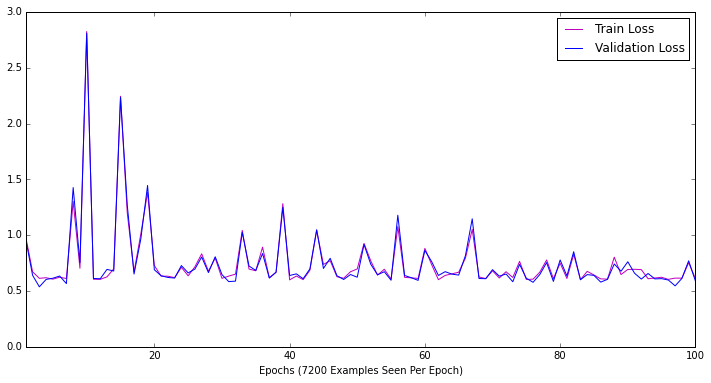

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_losses(train_losses, val_losses, epoch_examples, epochs, min_y, max_y):
    x1 = [a/epoch_examples for (a,b)  in train_losses]
    y1 = [b for (a,b)  in train_losses]
    x2 = [a/epoch_examples for (a,b)  in val_losses]
    y2 = [b for (a,b)  in val_losses]
    plt.figure(figsize=(12, 6))
    plt.axis((1, epochs, min_y, max_y))
    plt.plot(x1, y1, "-m", x2, y2, "-b")
    plt.legend(('Train Loss', 'Validation Loss'))
    xlabel = 'Epochs (%d Examples Seen Per Epoch)' %(epoch_examples)
    plt.xlabel(xlabel)
    plt.show()

plot_losses(train_losses, val_losses, 7200, 100, 0, 3.0)

### Code for Reloading the Saved Best Model

In [11]:
model = load_model_parameters_theano("./models/GRUs/GRU-20160425154620.npz")

Building model from ./models/GRUs/GRU-20160425154620.npz with hidden_dim=128 x_dim=1
